In [1]:
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import playerid_reverse_lookup
import pandas as pd
import numpy as np
import pyodbc
from pybaseball import cache
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import psycopg2
from sqlalchemy import create_engine
import pyodbc
from dateutil.relativedelta import relativedelta
from datetime import date

#### Connect to SQL Database

In [2]:
param_dict = {
    "host": "localhost",
    "database": "Baseball",
    "user": "postgres",
    "password": "Bullets10!"
}

param_dict = {
    "host": "localhost",
    "database": "Baseball",
    "user": "postgres",
    "password": "Bullets10!"
}

def connect(params_dict):
    "Connecting to PostgreSQL Database Server"
    conn = None
    try:
        print("Connecting to the PostgreSQL Database")
        conn = psycopg2.connect(**params_dict)
    except (Exception, psycopg2.DataError) as error:
        print(error)
    return conn

connect = "postgresql+psycopg2://%s:%s@%s:5432/%s" % (
    param_dict['user'],
    param_dict['password'],
    param_dict['host'],
    param_dict['database']
)
engine = create_engine(connect)

#### Load All Final Pitch Data

Final Pitch = Pitch that resulted in an event (In Play / Strikeout)

In [3]:
data = pd.read_sql_query("select * from final_pitch", con=engine)
data.head()

,batter_name,pitcher_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,events,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,"báez, javier","williams, devin",FF,2021-09-26,94.9,-2.08,5.42,595879,642207,field_out,...,1,3,8.0,1.0,None,2.0,1.40,1.31,1.31,28.9
1,"santander, anthony","patton, spencer",SL,2021-09-26,84.3,-1.83,5.23,623993,607359,field_out,...,1,3,4.0,1.0,None,NaN,3.41,-1.10,1.10,33.9
2,"alcántara, sergio","cabrera, génesis",CH,2021-09-26,92.3,0.89,5.91,642727,650893,field_out,...,1,3,2.0,1.0,None,2.0,1.68,1.04,-1.04,50.5
3,"france, ty","ramos, aj",CH,2021-09-26,82.3,-3.13,5.32,664034,573109,walk,...,1,4,2.0,1.0,None,1.0,3.33,1.34,1.34,31.6
4,"reynolds, bryan","medina, adonis",CH,2021-09-26,85.7,-2.15,5.89,668804,658431,force_out,...,1,4,5.0,1.0,None,1.0,2.78,1.78,-1.78,33.2


In [4]:
data.describe()

,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,pitch_zone,hit_location,balls,strikes,game_year,...,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
count,2.471509e+06,2.471243e+06,2.471243e+06,2.536527e+06,2.536527e+06,2.471245e+06,2.220371e+06,2.536527e+06,2.536527e+06,2.536527e+06,...,2.536527e+06,2.536527e+06,2.536527e+06,2.323122e+06,2.403450e+06,2.405477e+06,2.471237e+06,2.471237e+06,2.471237e+06,914385.000000
mean,8.881127e+01,-7.830785e-01,5.897381e+00,5.497292e+05,5.523965e+05,7.928176e+00,5.120879e+00,1.290213e+00,1.288337e+00,2.018351e+03,...,2.874031e+01,1.538582e+00,1.514616e+00,5.752981e+00,1.775499e+00,1.765915e+00,2.311216e+00,4.040092e-01,-1.204824e-01,38.842462
std,5.990488e+00,1.897952e+00,5.229120e-01,1.033189e+05,9.849062e+04,4.048402e+00,2.626285e+00,1.097391e+00,8.124279e-01,4.047465e+00,...,3.809076e+00,7.558560e-01,1.270878e+00,7.218183e+00,4.013853e+00,4.012254e+00,1.088168e+00,8.101794e-01,8.972726e-01,12.999648
min,3.010000e+01,-5.620000e+00,-1.300000e-01,1.100290e+05,1.106830e+05,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,...,1.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.700000e-01,-2.910000e+00,-2.970000e+00,-70.200000
25%,8.470000e+01,-2.140000e+00,5.630000e+00,4.650410e+05,4.764510e+05,5.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,2.015000e+03,...,2.600000e+01,1.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.440000e+00,-2.300000e-01,-8.800000e-01,32.100000
50%,8.990000e+01,-1.480000e+00,5.940000e+00,5.707310e+05,5.715780e+05,8.000000e+00,5.000000e+00,1.000000e+00,2.000000e+00,2.018000e+03,...,2.800000e+01,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,2.100000e+00,5.700000e-01,-2.200000e-01,40.000000
75%,9.350000e+01,1.000000e+00,6.230000e+00,6.413550e+05,6.256430e+05,1.200000e+01,8.000000e+00,2.000000e+00,2.000000e+00,2.022000e+03,...,3.100000e+01,2.000000e+00,2.000000e+00,6.000000e+00,2.000000e+00,2.000000e+00,2.950000e+00,1.070000e+00,6.400000e-01,47.100000
max,1.055000e+02,1.163000e+01,1.003000e+01,8.285990e+05,8.292720e+05,1.400000e+01,9.000000e+00,4.000000e+00,3.000000e+00,2.025000e+03,...,5.000000e+01,5.000000e+00,9.000000e+00,1.800000e+02,2.010000e+02,2.010000e+02,2.768000e+01,2.970000e+00,2.970000e+00,168.700000


In [5]:
data.isnull().sum()

batter_name                          0
pitcher_name                         0
pitch_type                       64469
game_date                            0
release_speed                    65018
                                ...   
batter_days_until_next_game     131050
api_break_z_with_gravity         65290
api_break_x_arm                  65290
api_break_x_batter_in            65290
arm_angle                      1622142
Length: 92, dtype: int64

#### Business Statement

Given a batted ball event, predict whether it will result in a home run based on its characteristics like exit velocity, launch angle, spray angle, etc.

For this, all we care about is any pitch that resulted in "hit_into_play"

In [5]:
data = data[data['description'] == 'hit_into_play']
data

,batter_name,pitcher_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,events,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,"rollins, jimmy","liriano, francisco",None,2012-03-28,NaN,NaN,NaN,276519,434538,field_out,...,1,0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,"figgins, chone","mccarthy, brandon",None,2012-03-28,NaN,NaN,NaN,408210,435221,field_out,...,1,0,NaN,NaN,None,1.0,NaN,NaN,NaN,NaN
3,"desmond, ian","niese, jonathon",None,2012-03-28,NaN,NaN,NaN,435622,477003,single,...,1,0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
4,"gwynn, tony","petit, yusmeiro",None,2012-03-28,NaN,NaN,NaN,448242,433589,field_out,...,1,0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
5,"núñez, eduardo","beachy, brandon",None,2012-03-28,NaN,NaN,NaN,456488,545404,field_out,...,1,0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536520,"reyes, josé","porcello, rick",SI,2014-08-10,89.9,-1.59,6.10,408314,519144,sac_bunt,...,2,9,3.0,1.0,None,2.0,2.23,1.50,-1.50,NaN
2536523,"mcdonald, john","cahill, trevor",SI,2013-08-24,91.8,-2.14,6.07,150348,502239,field_out,...,2,0,2.0,1.0,None,4.0,2.43,1.74,1.74,NaN
2536524,"bautista, josé","porcello, rick",SL,2014-08-10,88.4,-1.88,5.85,430832,519144,single,...,2,9,3.0,1.0,None,1.0,2.67,-0.16,-0.16,NaN
2536525,"ruiz, carlos","cahill, trevor",SI,2013-08-24,90.8,-2.14,6.28,434563,502239,double,...,2,8,2.0,1.0,None,2.0,2.12,1.64,1.64,NaN


#### Feature Engineering

<Figure size 2160x1080 with 0 Axes>

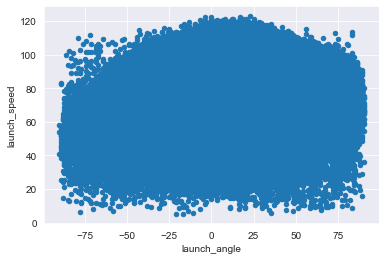

In [17]:
import seaborn as sns
plt.figure(figsize=(30, 15))
data.plot(kind="scatter", x='launch_angle', y='launch_speed')

plt.show()

In [9]:
data['is_home_run'] = (data['events'] == 'home_run').astype(int)

#### Look at home runs by pitch types

In [6]:
hr_df = data[data['events'] == 'home_run']
hr_df

,batter_name,pitcher_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,events,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
62,"pollock, aj","duffy, danny",FF,2012-03-31,94.9,2.80,5.79,572041,518633,home_run,...,1,0,NaN,NaN,None,NaN,1.19,0.43,-0.43,NaN
166,"de aza, alejandro","tomlin, josh",FF,2012-04-09,88.8,-1.33,5.92,457477,458708,home_run,...,1,0,NaN,1.0,None,2.0,1.55,0.25,-0.25,NaN
167,"jeter, derek","chen, wei-yin",FF,2012-04-10,88.6,2.50,6.18,116539,612672,home_run,...,1,0,NaN,1.0,None,1.0,1.18,0.66,-0.66,NaN
171,"desmond, ian","gee, dillon",FF,2012-04-10,90.4,-1.77,5.39,435622,518716,home_run,...,1,0,NaN,1.0,None,1.0,1.63,1.06,1.06,NaN
250,"jackson, austin","duffy, danny",FF,2012-04-16,96.8,2.34,5.71,457706,518633,home_run,...,1,0,6.0,1.0,None,1.0,0.77,0.19,-0.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536357,"álvarez, pedro","browning, barret",SL,2012-08-19,78.1,2.03,5.86,476883,446135,home_run,...,1,7,1.0,1.0,None,1.0,4.46,-1.50,-1.50,NaN
2536364,"pujols, albert","workman, brandon",FC,2014-08-09,87.7,-2.05,6.38,405395,519443,home_run,...,1,8,2.0,1.0,None,1.0,2.44,-0.18,-0.18,NaN
2536421,"santana, carlos","barney, darwin",CH,2016-07-01,86.3,-1.07,5.98,467793,446381,home_run,...,1,8,NaN,1.0,None,1.0,1.71,0.97,-0.97,NaN
2536430,"maldonado, martín","nuño, vidal",SI,2015-05-31,89.0,2.32,5.74,455117,573064,home_run,...,3,7,5.0,1.0,None,7.0,1.79,0.80,-0.80,NaN


In [17]:
home_run_pitches = hr_df.groupby('pitch_type')['batter_id'].count()
home_run_pitches

pitch_type
CH     7737
CS        3
CU     4360
EP       59
FA      107
FC     5038
FF    28629
FO       18
FS     1145
KC     1128
KN      181
SC        4
SI    12381
SL    11030
ST     1486
SV      159
Name: batter_id, dtype: int64

In [15]:
sns.barplot(data = home_run_pitches, x='batter_id', y='pitch_type', orient='h')

ValueError: Could not interpret input 'batter_id'

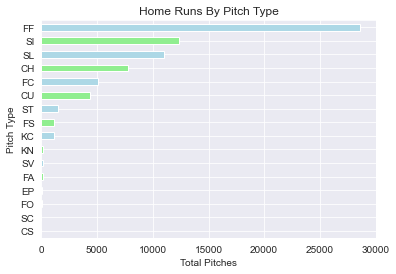

In [18]:
hr_df['pitch_type'].value_counts(ascending=True).plot.barh( color = ['lightgreen', 'lightblue'])
plt.title("Home Runs By Pitch Type")
plt.xlabel("Total Pitches")
plt.ylabel("Pitch Type")
plt.show()

In [4]:
### Filter down to one player (Lets look at Bryce Harper)
### Look at that players hits per pitch
### Look at total number of hits_in_play by pitch
### Look at the results for each pitch type
### Look at average exit velocity per pitch type
### Look at exit velocity given a specific location of the pitch


bryce_df = data[data['batter_id'] == 547180]
bryce_df

,batter_name,pitcher_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,events,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
681,"harper, bryce","smith, drew",CU,2022-05-08,76.1,-2.22,5.85,547180,622098,field_out,...,1,3,5.0,0.0,None,1.0,5.15,-1.43,1.43,45.0
2106,"harper, bryce","nance, tommy",FF,2022-09-06,94.1,-1.56,6.30,547180,667297,double,...,1,3,2.0,2.0,None,1.0,1.19,0.65,-0.65,41.9
2135,"harper, bryce","floro, dylan",CH,2022-09-08,86.4,-3.75,6.09,547180,571670,field_out,...,1,3,5.0,1.0,None,2.0,3.06,1.57,-1.57,32.7
2271,"harper, bryce","mayza, tim",SI,2022-09-20,95.1,1.78,6.44,547180,641835,strikeout,...,1,3,3.0,2.0,None,1.0,1.68,1.33,1.33,37.9
2473,"harper, bryce","jansen, kenley",FC,2022-10-15,93.4,-1.05,6.88,547180,445276,home_run,...,1,4,3.0,1.0,None,3.0,1.30,-0.76,0.76,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534165,"harper, bryce","smith, josh",SL,2020-09-12,86.2,-2.28,5.59,547180,595001,double,...,1,4,3.0,1.0,None,1.0,2.29,-0.54,0.54,NaN
2534801,"harper, bryce","stephenson, robert",FF,2021-04-25,96.6,-1.40,5.77,547180,596112,field_out,...,1,3,4.0,1.0,None,1.0,1.52,1.08,-1.08,43.4
2535081,"harper, bryce","garcía, yimi",FF,2021-05-19,96.4,-2.62,5.23,547180,554340,strikeout,...,1,3,3.0,1.0,None,1.0,1.17,0.80,-0.80,28.1
2535983,"harper, bryce","treinen, blake",ST,2021-08-11,87.6,-3.01,6.60,547180,595014,strikeout,...,1,3,1.0,1.0,None,1.0,2.95,-1.06,1.06,39.1


In [9]:
bryce_df['game_date'] = pd.to_datetime(bryce_df['game_date'])
bryce_df['year'] = bryce_df['game_date'].dt.year
bryce_df

,batter_name,pitcher_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter_id,pitcher_id,events,...,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,year
681,"harper, bryce","smith, drew",CU,2022-05-08,76.1,-2.22,5.85,547180,622098,field_out,...,3,5.0,0.0,None,1.0,5.15,-1.43,1.43,45.0,2022
2106,"harper, bryce","nance, tommy",FF,2022-09-06,94.1,-1.56,6.30,547180,667297,double,...,3,2.0,2.0,None,1.0,1.19,0.65,-0.65,41.9,2022
2135,"harper, bryce","floro, dylan",CH,2022-09-08,86.4,-3.75,6.09,547180,571670,field_out,...,3,5.0,1.0,None,2.0,3.06,1.57,-1.57,32.7,2022
2271,"harper, bryce","mayza, tim",SI,2022-09-20,95.1,1.78,6.44,547180,641835,strikeout,...,3,3.0,2.0,None,1.0,1.68,1.33,1.33,37.9,2022
2473,"harper, bryce","jansen, kenley",FC,2022-10-15,93.4,-1.05,6.88,547180,445276,home_run,...,4,3.0,1.0,None,3.0,1.30,-0.76,0.76,76.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534165,"harper, bryce","smith, josh",SL,2020-09-12,86.2,-2.28,5.59,547180,595001,double,...,4,3.0,1.0,None,1.0,2.29,-0.54,0.54,NaN,2020
2534801,"harper, bryce","stephenson, robert",FF,2021-04-25,96.6,-1.40,5.77,547180,596112,field_out,...,3,4.0,1.0,None,1.0,1.52,1.08,-1.08,43.4,2021
2535081,"harper, bryce","garcía, yimi",FF,2021-05-19,96.4,-2.62,5.23,547180,554340,strikeout,...,3,3.0,1.0,None,1.0,1.17,0.80,-0.80,28.1,2021
2535983,"harper, bryce","treinen, blake",ST,2021-08-11,87.6,-3.01,6.60,547180,595014,strikeout,...,3,1.0,1.0,None,1.0,2.95,-1.06,1.06,39.1,2021


In [15]:
bryce_df.groupby(['year', 'events'])['events'].count()

year  events               
2012  double                    27
      double_play                2
      field_error                4
      field_out                249
      fielders_choice            1
                              ... 
2025  sac_fly                    2
      single                    44
      strikeout                 75
      strikeout_double_play      1
      walk                      47
Name: events, Length: 213, dtype: int64